# w207 Spring 2019 - Final Project: Facial Keypoints Detection

by Michael Berger, Andre Fernandes, Vivian Lu, Sam Tosaria, and Pauline Wang.

Date: April 12, 2019

## Abstract
**(TBD)**


## Introduction

The goal of our project is to build a well-performing machine learning algorithm to determine 15 facial keypoints from an image of a human face.  The data we use for training and testing is from the Kaggle [facial keypoint detection competition](https://www.kaggle.com/c/facial-keypoints-detection), which consists of 7000+ facial images of men, women and children.   

We have, essentially, a regression problem. Each facial keypoint has an x and y coordinate, leading up to 30 variables that need to be predicted using 96x96 pixel values from an image. However, due to multiple angles, orientations, and resolutions in our training images, the problem becomes particularly challenging to solve with simply a regression algorithm. 

Our report below thus utilizes a combination of **data augmentation and Convolutional Neural Networks (CNN)** to build a machine learning model. As a baseline, we use a simple CNN with no hidden layer, trained on the raw images with complete labels. The metric we used for measuring error is the same as the kaggle competition: the root mean squared error (RMSE) which is defined as:

$RMSE = \sqrt{ \frac{1}{n} \sum^n_{i=1} (y_i - \hat{y}_i)^2}$

The RMSE measures the average distance of each team's model predictions from the true coordinates of the 15 keypoints on the face.  For example, an RMSE of 3.00 means that, on average, the predictions are three pixels away from the true keypoint x or y coordinate.

### Report Outline

Our analysis as summarized in this Jupyter Notebook is structured as follows:

**Part I**

- Exploration Data Analysis (EDA)

- Baseline Model
    - Data Tranformation
    - Model Buildling
    - Sectional Summary
    
**Part II**

- Data Augmentation
    - Image Rotataion 
    - Inputing missing coordinates

- Extension: Combining Classification and Regression Models
    - Classification CNN
    - Regression CNN
    - Combining predictions

- Summary of model comparison

- Conclusion
 

## Part I

## Exploration Data Analysis

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

`left_eye_center`, `right_eye_center`, `left_eye_inner_corner`, `left_eye_outer_corner`, `right_eye_inner_corner`, `right_eye_outer_corner`, `left_eyebrow_inner_end`, `left_eyebrow_outer_end`, `right_eyebrow_inner_end`, `right_eyebrow_outer_end`, `nose_tip`, `mouth_left_corner`, `mouth_right_corner`, `mouth_center_top_lip`, `mouth_center_bottom_lip`

Left and right here refers to the point of view of the subject.

In some examples the target keypoint positions are missing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0, 255). The images are 96x96 pixels.

We first import all the libaries required to build our model: 

In [4]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')
import importlib
import Berger_Fernandes_Lu_Tosaria_Wang_Baseline as facial_functions
workDir = os.getcwd()

Using TensorFlow backend.


In [6]:
df_train, df_test = facial_functions.read_train_and_test(
                                        os.path.join(workDir, "data", "training.csv"),
                                        os.path.join(workDir, "data", "test.csv"))

# Not displaying the last image column (for display purposes)
df_train.loc[:,'left_eye_center_x':'mouth_center_bottom_lip_y'].head(10)

Note from above that the pixel values are all squeezed into the last column and the labels are split in x- and y-coordinates (alternating) in the columns before. For display purposes, the last column of pixel values was not included. We next transform this data to get one dataset with only the pixel values, with each pixel being in one column.

In [3]:
# Processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = facial_functions.preprocess_pixels(df_train)
kaggle_train.head()

0    1    2    3    4    5    6    7    8    9     ... 9206 9207 9208 9209  \
0  238  236  237  238  240  240  239  241  241  243  ...   33   29   30   34   
1  219  215  204  196  204  211  212  200  180  168  ...    1    1    1    1   
2  144  142  159  180  188  188  184  180  167  132  ...   64   60   56   61   
3  193  192  193  194  194  194  193  192  168  111  ...    1    1    1    1   
4  147  148  160  196  215  214  216  217  219  220  ...   33   34   37   37   

  9210 9211 9212 9213 9214 9215  
0   39   49   62   70   75   90  
1    1    1    1    1    1    1  
2   70   69   71   78   78   77  
3    1    1    1    1    1    1  
4   43   46   83  140  170  176  

[5 rows x 9216 columns]

We do a quick check for missing values in the pixel data for the training set: 

In [4]:
# Missing values kaggle_training?
print("Missing values pixel data:", kaggle_train.columns[kaggle_train.isnull().any()].tolist())

Missing values pixel data: []


While there are no missing values in the pixel data, there are missing values in the labelled facial keypoints data. 


In [5]:
# Missing values in labels?

labels = facial_functions.create_labels(df_train,0,30) 

print("Missing values labels:", labels.columns[labels.isnull().any()].tolist())

Missing values labels: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']


Thus, for each facial feature (both x and y coordinates), we check to see if the images generally have all 15 facial keypoints. Below, we can see in the bar graph that the percentage of missing values can be as high as 68%, especially on labels for the eye corners, eyebrows, mouth corners, and the mouth upper lip. 

This means we have an imbalance in the number of examples per value that we want to regress on. We can think about increasing the number of training data by image transformations, like mirroring, or try to augment the missing labels. For the baseline model, however, we decided to only take the observations with no missing label information.

Text(0.5, 1.0, 'Features and Corresponding Counts of Available Data (Train Set)')

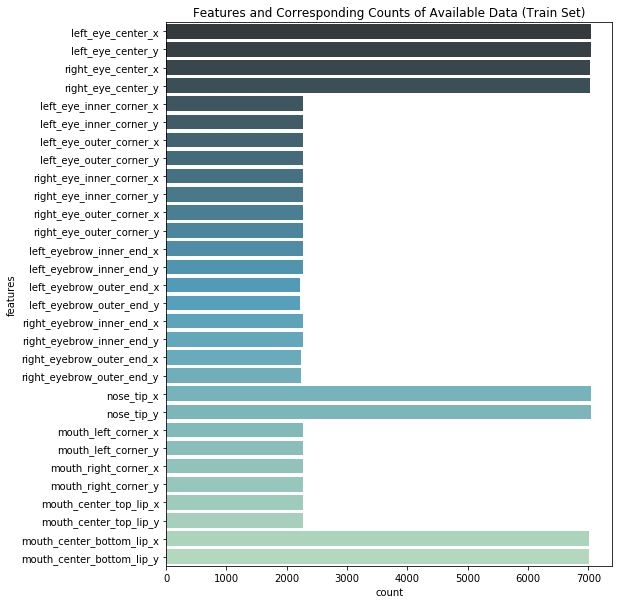

In [6]:
facial_functions.plot_label_counts(labels)

We take a similar look at the test data below, first preprocessing it (again, where the last column contains the pixel values) and then checking for missing values.

In [7]:
# processing test data such that each pixel has its own column
kaggle_test = facial_functions.preprocess_pixels(df_test)
kaggle_test.head()

0    1    2    3    4    5    6    7    8    9     ... 9206 9207 9208 9209  \
0  182  183  182  182  180  180  176  169  156  137  ...    6   14   28   28   
1   76   87   81   72   65   59   64   76   69   42  ...  156  152  162  169   
2  177  176  174  170  169  169  168  166  166  166  ...    1    1    1    1   
3  176  174  174  175  174  174  176  176  175  171  ...  144  143  141  142   
4   50   47   44  101  144  149  120   58   48   42  ...  254  254  254  253   

  9210 9211 9212 9213 9214 9215  
0   24   18   12    8    5    5  
1  168  159  191  228  211  168  
2    1    1    1    1    1    1  
3  143  142  142  142  142  140  
4  255  236  174  175  175  165  

[5 rows x 9216 columns]

We note the dimensions of our training data vs testing data: 
* As expected, there are 9216 (96 x 96 pixels) columns in both sets to represent our images. 
* Training data has a total of 7049 images, while the testing data has a total of 1783 images. 

In [8]:
# Shapes
print("Train data shape:", kaggle_train.shape)
print("Test data shape:", kaggle_test.shape)

Train data shape: (7049, 9216)
Test data shape: (1783, 9216)


Below, we see that we have no missing values in our test set pixels.

In [9]:
print("Missing values pixel data:", kaggle_test.columns[kaggle_test.isnull().any()].tolist())

Missing values pixel data: []


To get a sense of what the images look like along with their facial keypoints, we proceed to plot 20 images with the corresponding facial keypoints.

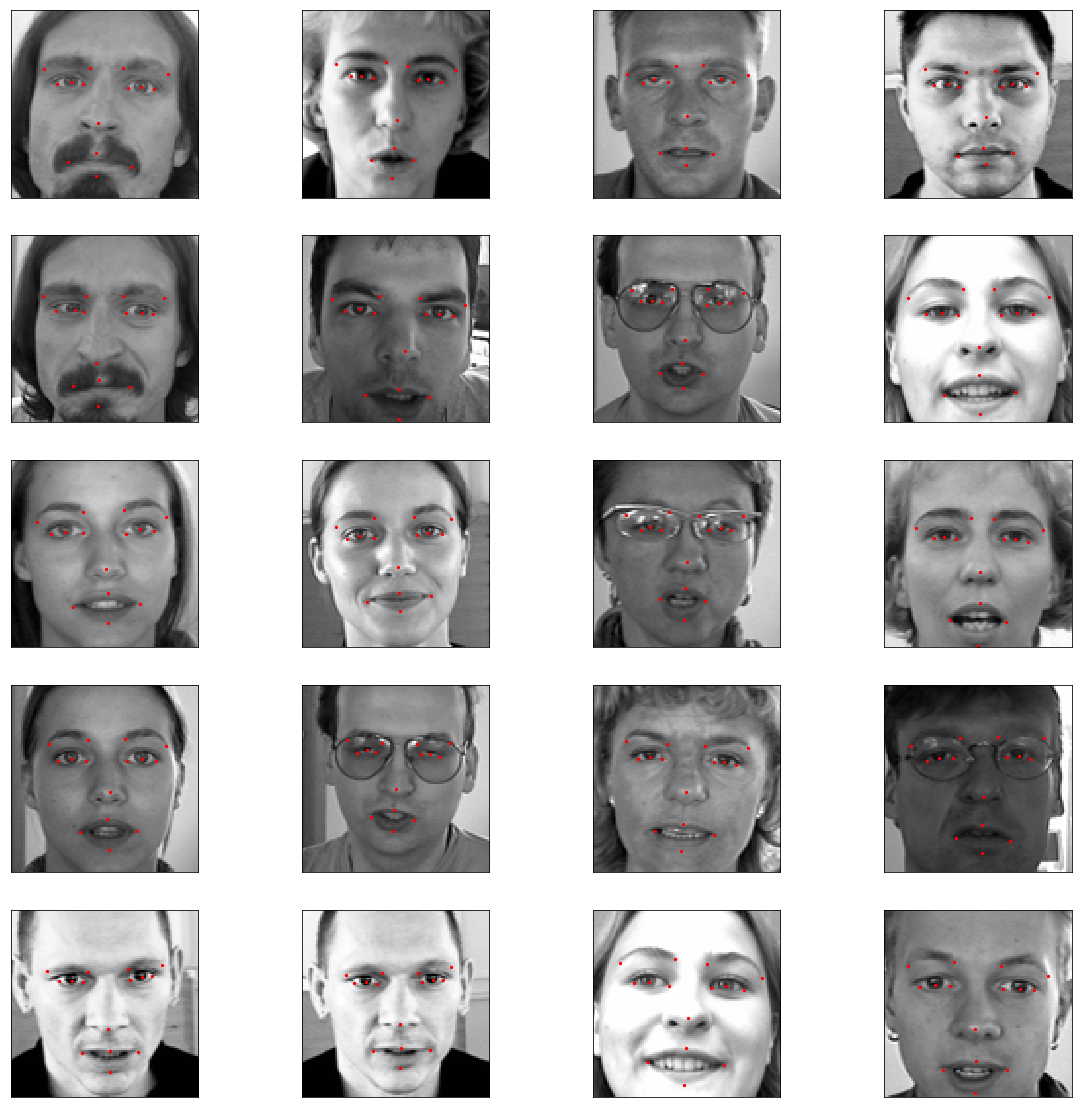

In [10]:
# Plotting some of the image data with keypoints
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()

To get a sense of images with missing facial keypoints, we plot a few of them below. 

In particular, we note the following: 
* Some facial features are cut off at the image border and therefore are 'missing'. 
* Facial orientation (i.e. sideview) can distort what features are visible 
* Items such as glasses and hair can block facial features, and thus are 'missing'.

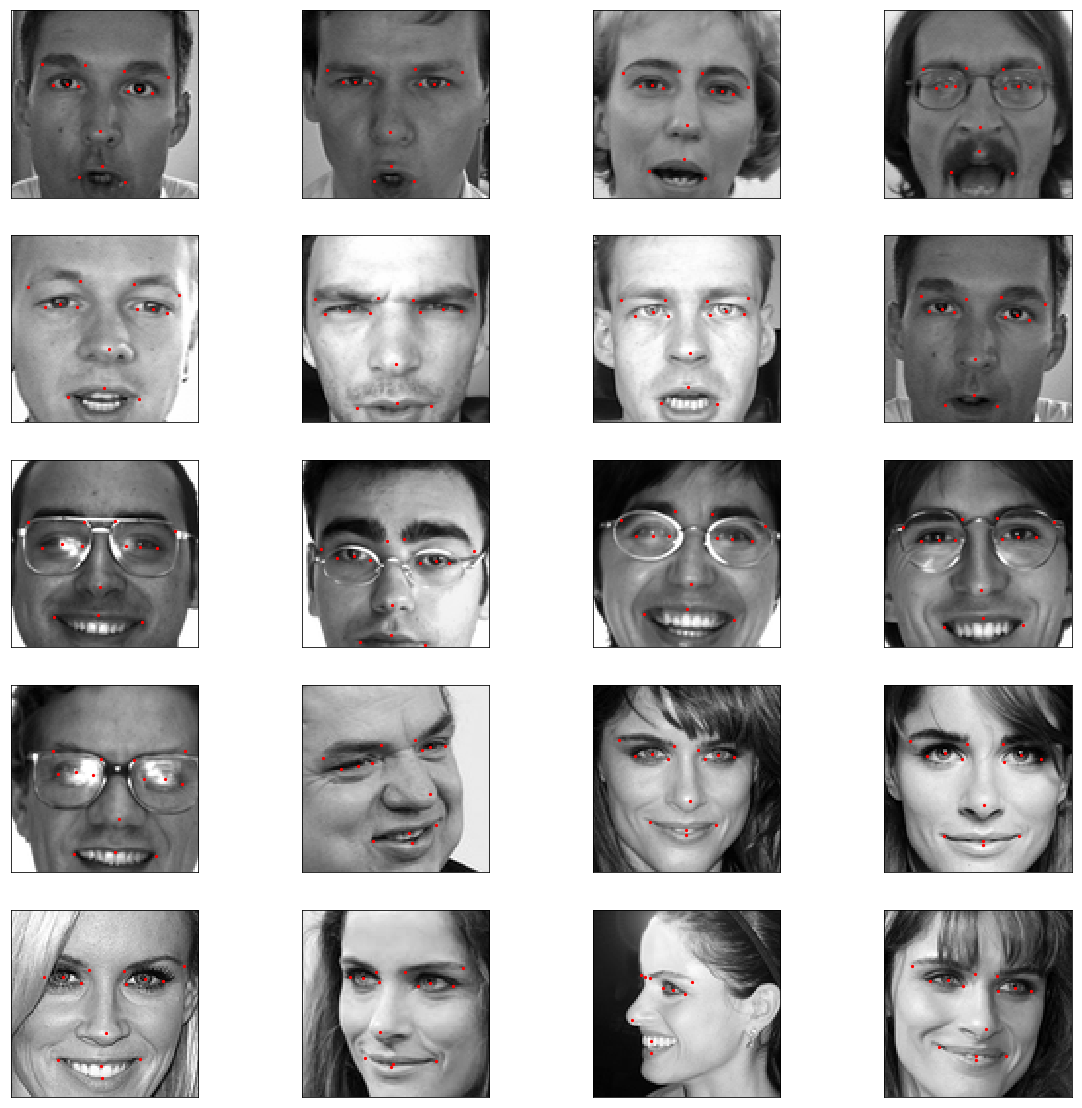

In [11]:
# Plotting some images with missing keypoints 
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(labels.shape[0]):
    
    if sum(labels.iloc[index,:].isnull()) == 0:
        continue
        
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1
    
    if position > 20:
        break

plt.show()

## Baseline Model##

In this section, we illustrate classifying facial key points using a simple neural network model with no hidden layer as our baseline model. The purpose of the baseline model is to compare and contrast the improvement of classifer with our data augumentation and feature engineering in the subsequent sections.  We will also use the baseline model to evaluate the performance of the hidden layers .  

### Data Transfomation
We first drop all the images that contains one or more missing facial keypoint values.  From the EDA section, we identify only 2140 images out of the total 7049 with all 30 facial keypoint intact.  We refer to these images as "High Quality" and will run our baseline CNN model based on this subset of images.  We ran through a list of codes below to transform the data into our desired shape and format. 

In [21]:
# We drop all images with mising value which left us with 2140 images. 
# We examine the shape of the data to make sure that it is correct. 
norm_x_train, labels_no_na, non_na_index = facial_functions.separate_non_missing(kaggle_train, labels, normalize=True)

Correct shape for train features? (2140, 9216)
Correct shape for train labels? (2140, 30)


### Normalizing Data and Splitting Training Data in Training and Validation Data

As the Kaggle test set comes without labels, we will use the training data and split the data into a validation set and a training set. The validation set is used to compare the performance of different model specifications on the same unseen test data.

In [22]:
train_data, train_labels, val_data, val_labels = facial_functions.split_train_and_test(norm_x_train, 
                                                                                       labels_no_na, 
                                                                                       percent=.8,
                                                                                       seed=123)

validation set shape (20%): (428, 9216) (428, 30)
train set shape (80%): (1712, 9216) (1712, 30)


In [23]:
train_data, train_labels = facial_functions.reshape_image(unshaped_train_data, unshaped_train_labels, "train")
val_data, val_labels = facial_functions.reshape_image(val_data, val_labels, "val")

val feature shape (428, 96, 96, 1) val labels shape (428, 30)


### Model Building

We instantiate a sequential model with no hidden layer as our baseline model with most of the default hyperparameters.  We select the activation function, softmax, as it calculates the probabilities of each target class over all possible target classes. The output dimension is 30 as there are 15 pairs of x, y coordinates and the imput dimension is 9216 to represent the 96 x 96 pixels. We then run the optimizer, setting the learning rate to be 0.01 and using 200 epochs, to calculate the accuracy and loss of our baseline model.  

We plot out our baseline model accuracy and loss with 100 epochs. As indicated by the plots below, the root mean square error decreased drastically between 0-25 epoches and plateaued after that.  This indicates that our model does not learn well with the increasing number of epoches. **The result suggests that we are likely to improve our model performance by introducing additional layers**. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                276510    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
Total params: 277,440
Trainable params: 277,440
Non-trainable params: 0
_________________________________________________________________
None
Train on 1712 samples, validate on 428 samples
Epoch 1/5
1712/1712 [==============================] - 2s 1ms/step - loss: 347.5089 - mean_squared_error: 347.5089 - r_square: 0.7260 - rmse: 16.7761 - val_loss: 137.0703 - val_mean_squared_error: 137.0703 - val_r_square: 0.6129 - val_rmse: 11.6084
Epoch 2/5
1712/1712 [==============================] - 2s 885us/step - loss: 130.4157 - mean_squared_error: 130.4157 - r_square: 0.6320 - rmse: 11.3183 - val_loss: 108.8576 - val_mean_squared_error: 108.8576 - val_r_square: 0.6930 

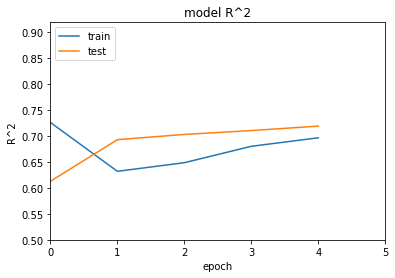

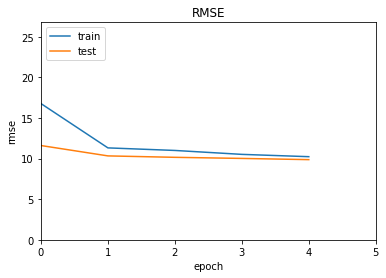

Validation RMSE: 9.871548037662684
Performance increase relative to baseline: -0.0%


In [10]:
model, total_time = facial_functions.run_baseline_model(train_data, train_labels, val_data, val_labels, 
                                                        epochs=5, lr=.01, seed=123)

Next, we put our predicted labels on the facial images to see how they perform.  As expected, the facial images with any kind of distortation (e.g. face tilted to an angle) or obfuscation (e.g. hats, sunglasses, bangs) are particually inaccurate in how the keypoints are labeled.   

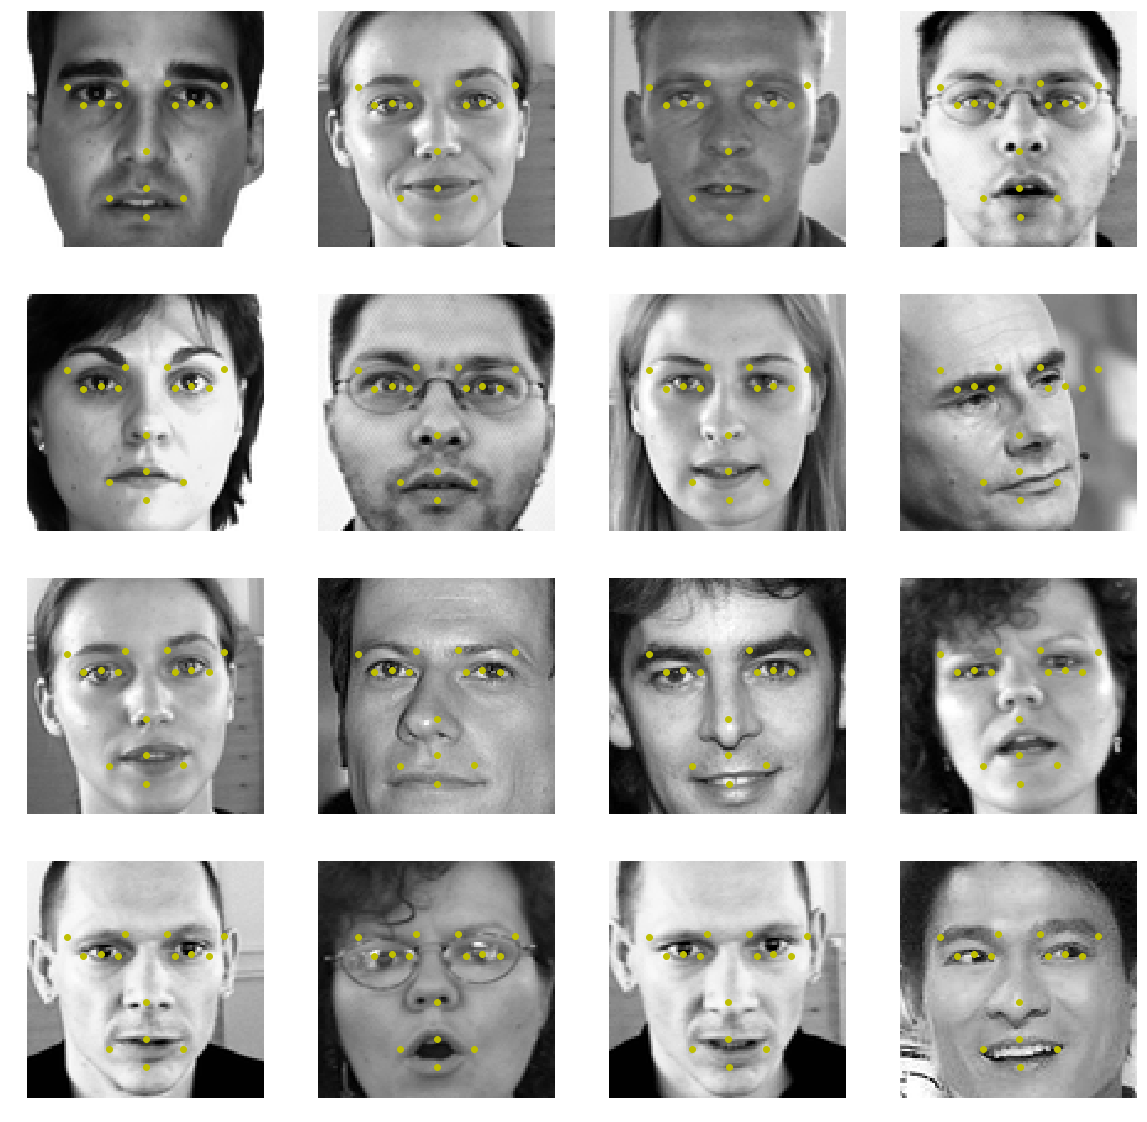

In [30]:
#we plot the prediction with facial images

def plot_faces_with_keypoints_and_predictions(model, nrows=4, ncols=4, model_input='flat'):
    """Plots sampled faces with their predicted labels."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False) #prints a list of random number 
    fig, axes = plt.subplots(figsize=(20, 20), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions=predictions.reshape(15,2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'yo')
        ax.axis('off')
      
plot_faces_with_keypoints_and_predictions(base_model)

In [33]:
def predictions_vs_labels(index):
    '''This function plots the predicted label from our baseline model vs the actual label'''
    index=index
    plt.imshow(X_train[index, :, :, 0], cmap = 'gray')
    predict_list=[]
    
    for i in range(0,2140): # we save all the prediction to a list
        img=X_train[i,:,:,0]
        predictions = base_model.predict(img.reshape(1, -1))
        predict_list.append(predictions)
        
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(y[index][coord], y[index][coord+1], c = 'red', s = 7) #plot the actual label
            plt.gca().scatter(predict_list[index][0][coord],predict_list[index][0][coord+1], c='yellow', s=7 )#plot the prediction
    plt.show()

### Sectional Summary ###

From the accuracy and loss plots above, it's apparent that our model overfits and therefore the performance is weak on the validation set, regardless the number of epoches.  The predicted labels are fairly similiar regardless of the images, suggesting that the model's learning rate plateaued after several epoches.  Below are a few key reasons for our baseline model's poor performance.

- **Insufficient training data**: Our EDA shows that only 2140 images have all labels intact.  By excluding images with missing labels, we reduced our training data size by 70%.  


- **Suboptimal model performance**: The model performance plots show that RMSE plateued after several epoches. This suggests that we need to modify our CNN by introducing hidden layers or changing the hyparameters. 


- **Image augmentation is required**: As shown in the images below, our model is weak in predicting facial images that are distorted, tilted or obfuscated. We will need to reprocess these images by introducing additional features or by data augmentation

--------Example of an image with obfuscations--------
The baseline model mistakened the frame of the glasses as eyebrows


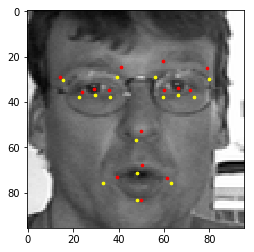

--------Examples of a tilted image--------
The predicited labels assume that key points are symmetry which perfrom poorly when the facial images are at an angle.


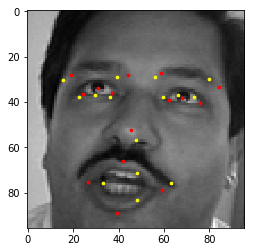

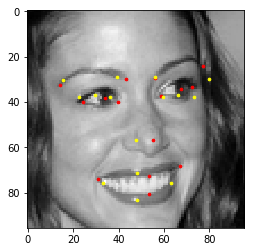

In [37]:
print ("--------Example of an image with obfuscations--------") 
print ("The baseline model mistakens the frame of the glasses as eyebrows")
predictions_vs_labels(24)
       
print ("--------Examples of a tilted image--------")
print ("The baseline model predicts that facial key points are symmetrcal which perfrom poorly when the images are at an angle.")
predictions_vs_labels(980)
predictions_vs_labels(1775)

## Changing Model Infrastructure:  Incorporating CNN

In the next sections, **we will explore methods to improve our model through feature engineering and data augmentation to increase our training set**. At each stage of the transformation as outlined below, we will introduce additional layers with hyperparameters and number of neurons that are most optimal to the "new" training set and compare the performance with our baseline model.   

Initially we faced difficulty feeding the image vectors into the model. We used the Keras library with a Tensorflow(TF) backend. The backend options of TF and Theano are mostly interchangeable without much difficulty. However when it comes to image processing, the default input parameters for the two backends vary. The default color parameter in Theano comes first (color parameter, x-axis array, y-axis array), meanwhile TF expects the color parameter after the image specifications. 

The convolution layers apply a filter and reduce the feature set. The structure and the parameter values we arrived at are based on an empirical approach combined with rules of thumbs developed by other practitioners in the field. The small receptive field (kernel size = (3, 3)), small incremental strides and the expanding depth of the convolutional layers achieved better results. The stepwise increase in the depth of the convolutional layers allows the neural network to increase the capacity to learn without down sampling and find an increasing number of spatial relationships in the data. 

We used an empirical approach to the deciding the number of neurons in the fully connected layers, and varying the numbers between 100 and 500 did not change the result. The choice of ‘ReLU’ activation layers speeds up the learning rate at the different layers. Building on what we learnt from the baseline model, maintaining the ‘softmax’ activation function for the final thirty neuron output layer allowed for a smoother learning rate. 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
__________

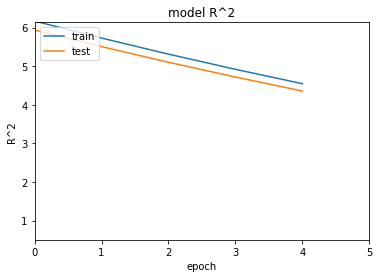

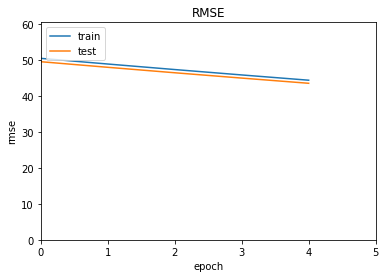

Validation RMSE: 43.48128423958181
Performance increase relative to baseline: -340.47%


In [11]:
cnn_model, cnn_total_time = facial_functions.run_cnn_model(train_data, train_labels, val_data, val_labels, 
                                                        epochs=5, lr=.01, baseline=model[1], seed=123)

## Changing Model Infrastructure:  Adding Dropout and Batch Normalization

### Andre's write up goes here

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        256       
__________

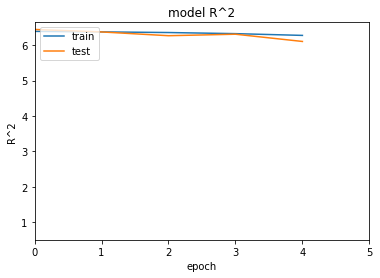

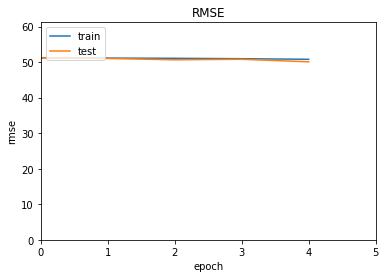

Validation RMSE: 50.08185383092577
Performance increase relative to baseline: -0.0%


In [16]:
new_cnn_model, new_cnn_total_time = facial_functions.run_regularized_cnn_model(train_data, train_labels, val_data, val_labels, 
                                                        epochs=250, lr=.0005, batch_size=50, dropout=.1, baseline = model[1])

## Data Augmentation
When working with smaller datasets, data augmentation is a promising technique that can enable better results. It boils down to increasing the number of training examples by applying transformations to available data with the hopes that it will allow your model to generalize better.

### Original Concept
To increase the training data set we plan to **transform the images and the the associated facial point locations**. Since we want our model to learn meaningful characteristics about the anatomy of a human face, as opposed to relying on repeated locational patterns (e.g. left eye usually being located in top left of image), we believe that applying transformations like rotation, flipping, and angling can help our model build a better representation of a human face. This approach looks like the following transformed images:

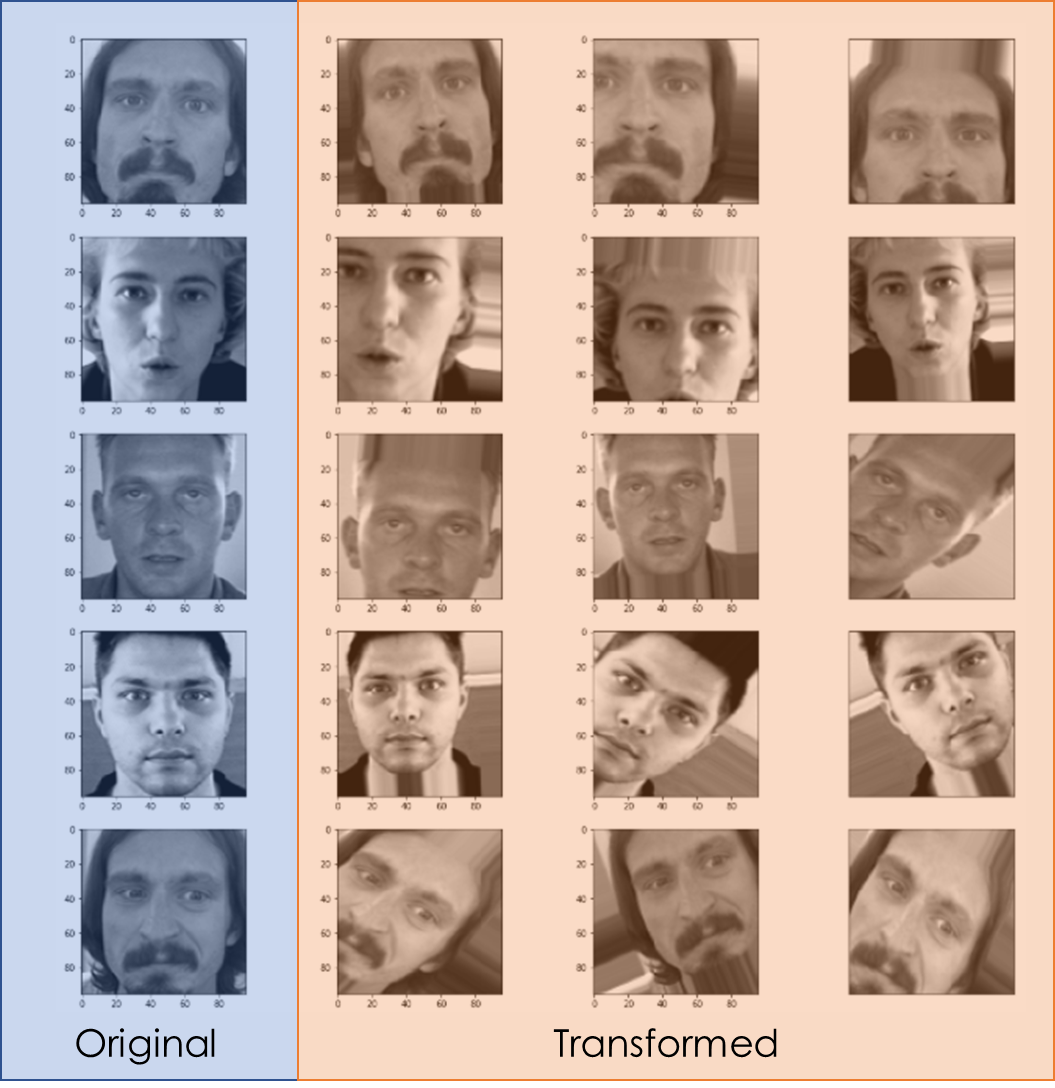

In [12]:
from IPython.display import Image
Image(os.path.join(workDir, "images/data_augmentation_original_concept.png"))

Below is the commented out code we used to create computer generated images:

In [13]:
# aug_train_data = facial_functions.generate_new_images(train_data, batch_size=10, rotation_range=10).astype(int)
# aug_train_data.to_csv(os.path.join(workDir, "data", "augmented_train_data.csv"))

### Roadblocks
The technique described above has been successfully used to achieve better results in image classification problems. However, the facial feature detection problem that we are presented with is not a classification problem—it is a multiple regression problem. This is an important distinction, and here is why: in a standard image classification problem, let’s say “is this an image of a cat”, the label that we are trying to learn is whether or not the image contains a cat. If we apply transformations like rotating, flipping, or angling to the images, the label remains unchanged. In this facial feature detection problem, our labels are the pixel location of the features (X and Y coordinates). This makes the applying of data augmentation transformation to the images much harder because the same transformations would need to be applied to our labels. Although this is possible to do, it requires extensive amount of work that is outside the scope of this project. However, this brings us to the next piece of our data augmentation puzzle:

### Imputing Feature Location

In addition, we look into possibly **imputing the missing coordinates of the facial features**. Specifically, we look at Adam Geitgey's package face_recognition (https://github.com/ageitgey/face_recognition). Given an image, face_recognition provides an output of 68 labelled points (each with x,y coordinates) corresponding to the eyebrows, eyes, nose bridge, nose tip, upper lip, lower lip, and facial jaw outline.  

The challenge with utilizing a foreign package includes the following: 
* Condensing the relevant points within the provided 68 labelled points into 15. While this is easy for some features (i.e. eyebrows and eyes), the keypoints on the mouth are definitely harder in particular when the face is tilted or shifted a certain way. 
* We may be introducing extra bias as the keypoints determined by an external package may be different than how the original facial keypoints were created. 

Given that we have such a small set of images with a full complete set of all 15 labelled facial keypoints, we felt that some introduced bias in the presence of getting more data is worth it in order to get more training data for the CNN model. We expect the added facial key points will increase our model performance by expanding the training data set. 

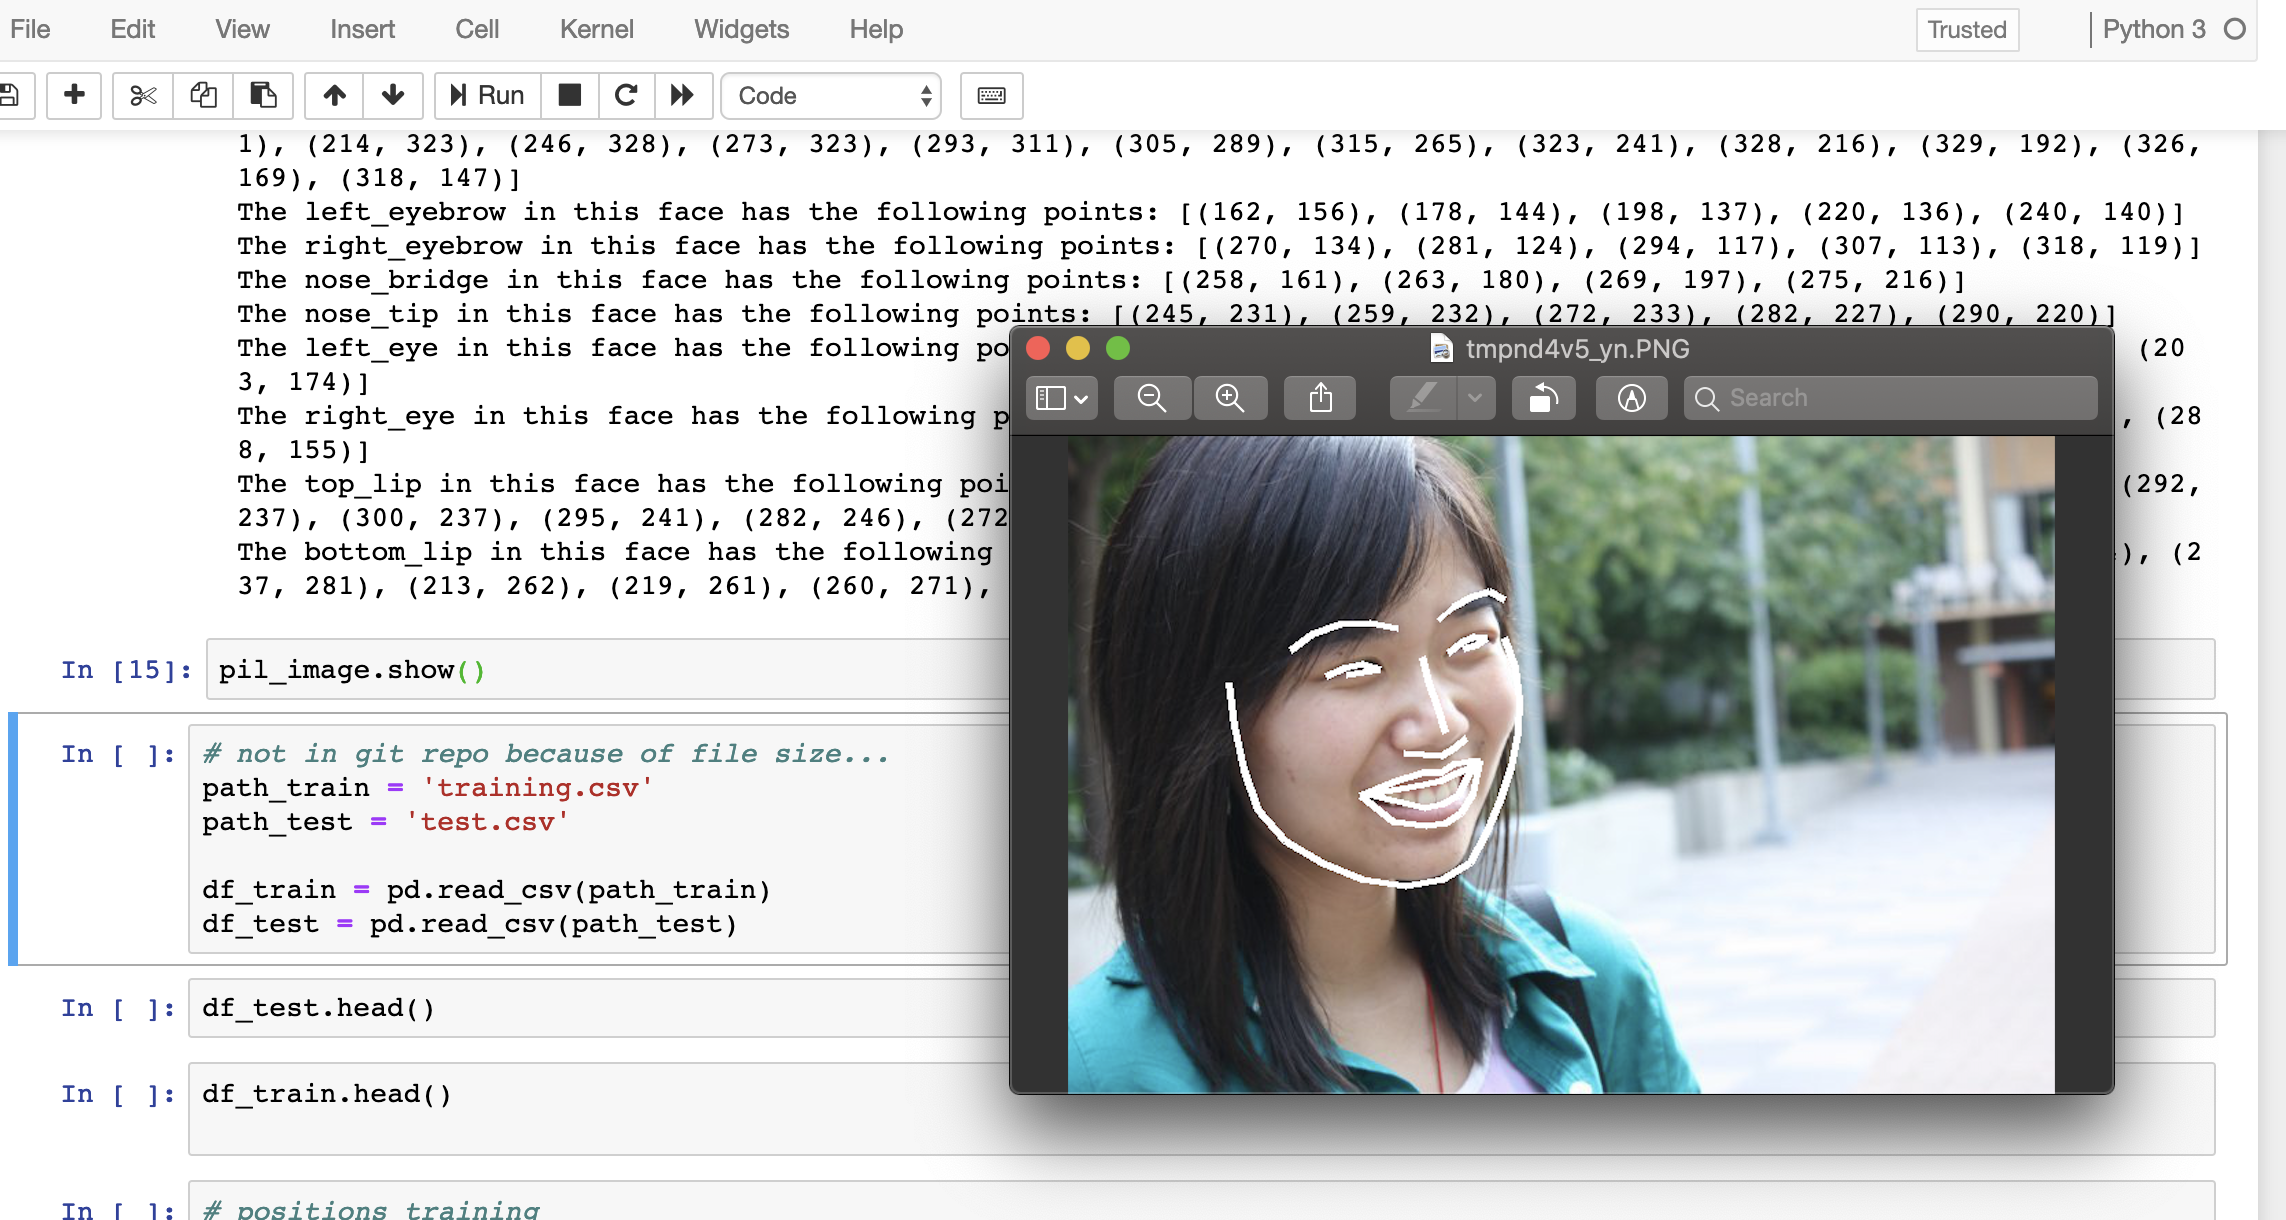

In [14]:
Image(os.path.join(workDir, "images/vivian_screenshot.png"))

Below is the commented out code we used to impute the missing labels and information about the results:

In [17]:
##################
# Don't run this unless you want to install face_recognition 
##################

#import dlib
#import face_recognition #https://github.com/ageitgey/face_recognition 

#data = pd.read_csv("augmented_train_data.csv")
#data_df = data.drop(['Unnamed: 0'], axis=1)

#**Note**: You can input here whichever file you are looking at 
#Ex: You can input in the original training.csv (kaggle_train in our case) 
#For this particular segment of code, data_df comes from loading the "augmented_train_data.csv" 

#unable_list=[] #this holds indexes where we are unable to get coordinates 

#new_coordinates = [] #this holds the new coordinates 

#for index, row in data_df.iterrows(): 
#    array_image = get_image_and_save(index) 
#    array_image.save('foo.jpg')
#    image_test = face_recognition.load_image_file("foo.jpg")
#    image_test_labels = face_recognition.face_landmarks(image_test)
#    if (len(image_test_labels)==0): #face_recognition was unable to detect anything
#        unable_list.append(index) #append index 
#    else: 
#        created_labels = make_points(image_test_labels, index)
#        new_coordinates.append(created_labels)

#new_labels = []
#for i in range(len(new_coordinates)): 
#    new_labels.append(pd.DataFrame(new_coordinates[i]).T)

#edited_labels_df = pd.concat(new_labels).reset_index(drop=True)

#edited_labels_df['row_index']=edited_labels_df['row_index'].astype(int)

#edited_labels_df.to_csv('augmented_train_data_predicted_coordinates.csv', index=False) #spit out new imputed points

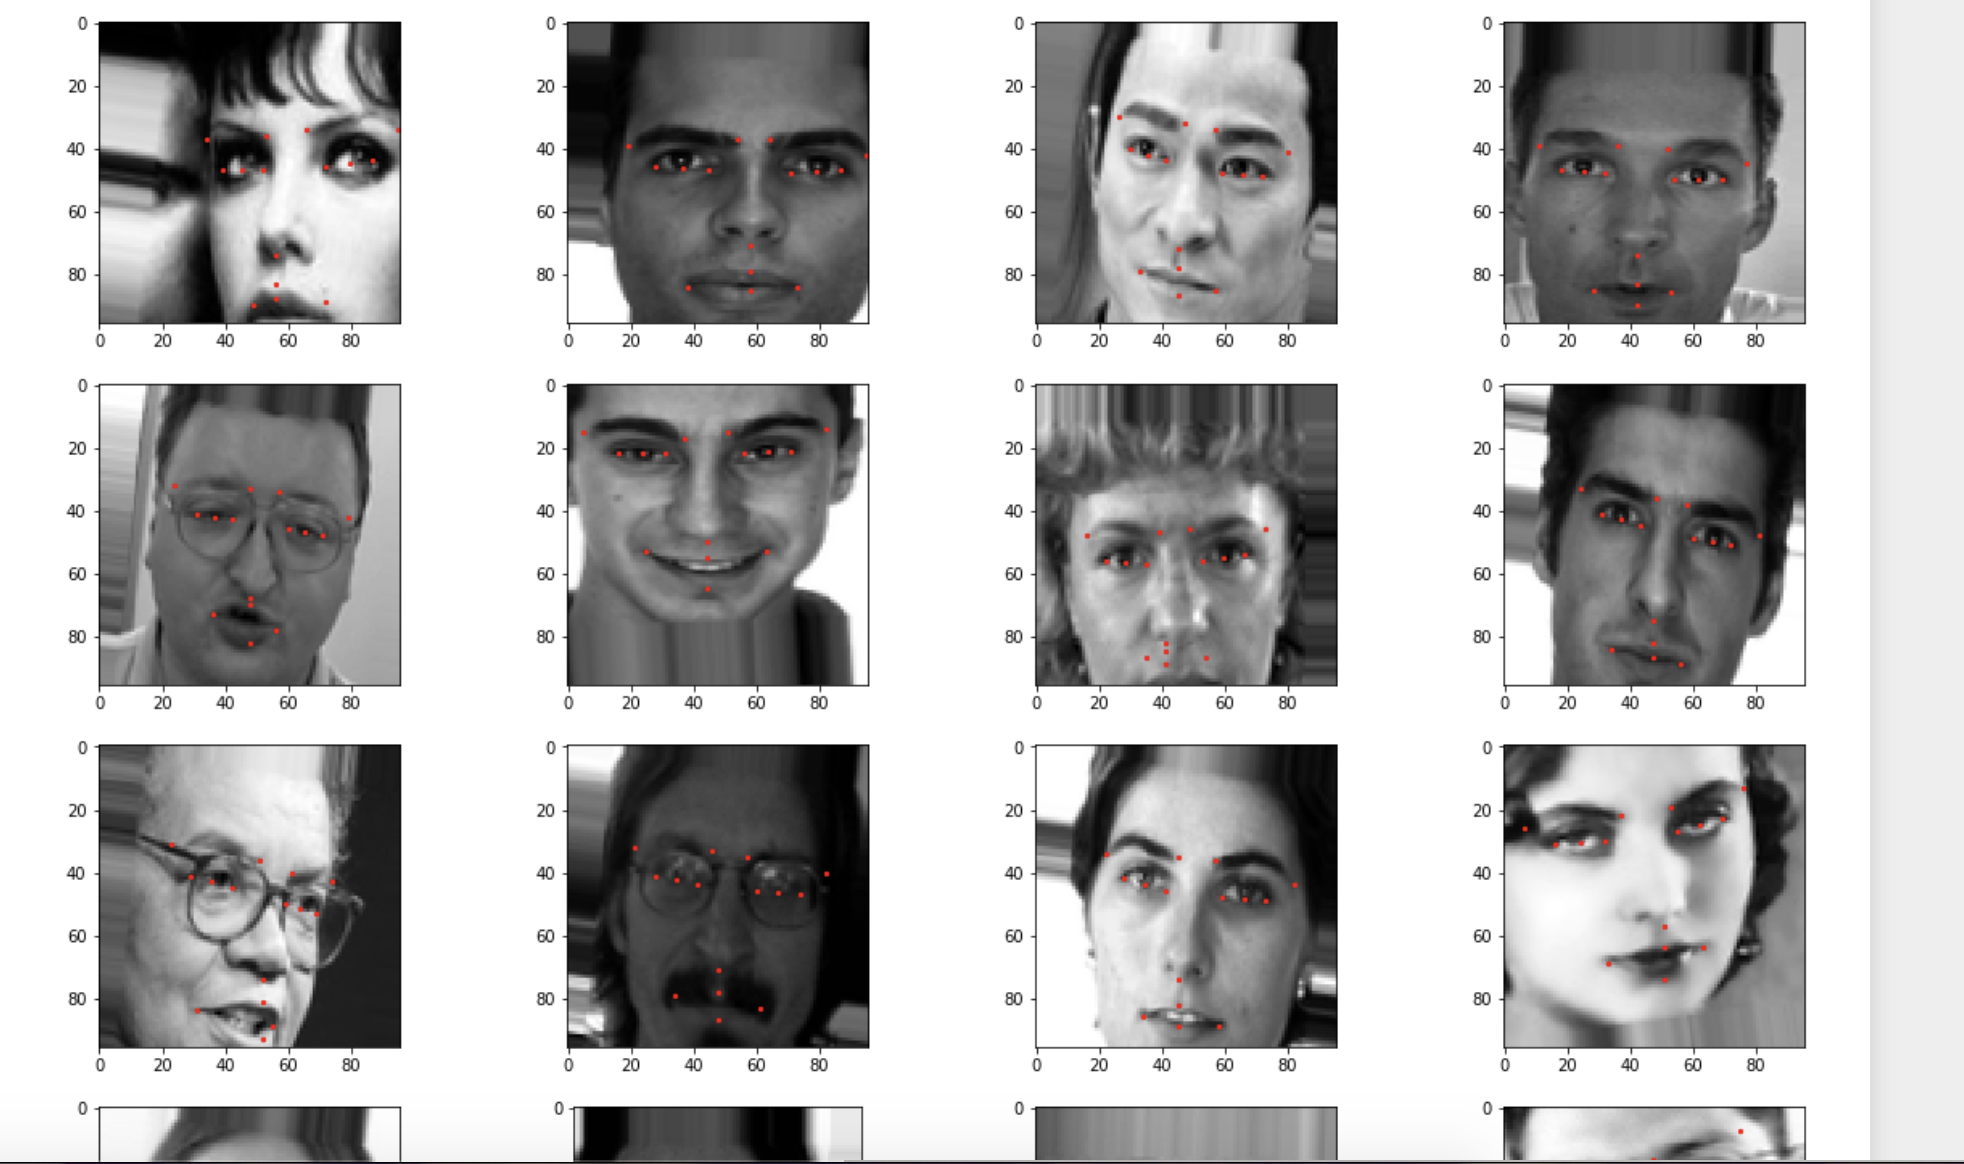

In [15]:
Image(os.path.join(workDir, "images/vivian_results.png"))

### Horizontal Flipping

Now, while rotating the images and angling them create an extensive list of problems in applying the same transformation to the labels, the same is not true for flipping the images horizontally. Flipping the images horizontally, and adjusting the labels for the flips (e.g. right eye coordinates become left eye coordinates), enables us to double the size of our data and achieve some of the benefits of adding new perspectives to our model. This technique looks like this:

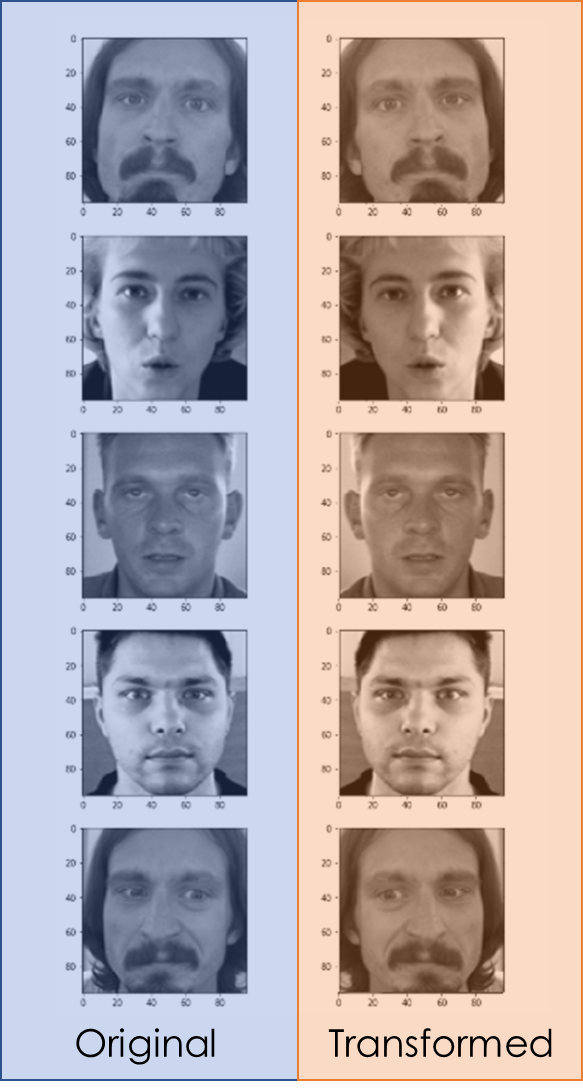

In [18]:
Image(os.path.join(workDir, "images/data_augmentation_revised_concept.png"))

Here is the code we used to run this: (this might actually be able to run in the final report--will depend on how long it takes)

In [19]:
# commented out code that doesn't exist yet

### Sam's Section (is this still being done?)

Lastly, we will explore **training a single layer using eigen vectors of the faces while optimizing using PCA**. We plan to  save and extract this layer and feed it into a multilayer neutal net.  This step will help us reduce dimensionality and improve model performance by avoid overfitting.

## Combining Data Augmentation and Modeling

In this section we will train a new model using the newly created data:

In [20]:
# another modeling function that looks just like the above, hopefully we get better results

## Extension: Combining Classification and Regression Models

**An assumption we made in our modeling so far is that our data will always have all facial keypoints present.** This assumption might not hold in reality (and for the kaggle leaderboard test set!). Hence, we think it might make sense to install a **classification model to predict which keypoints are present** and **then run a regression model on the keypoints classified as being present**. To do that we will use two CNN models. Besides the last layer for the classification model, both models will have the same architecture as the last CNN model we added with dropout and batch normalization. Thus, for the classification we predict whether a coordinate is present or not.

The last layer of the classification model will have a sigmoid activaition function to output the probabilities and treat the loss of each node individually. In addition, the model will use a binary crossentropy loss function as we assume that each class will be independent and will either be present or not present.

We will then adjust for the independence assumption as each keypoint has a x- and y-coordinate. In case the model predicts a sufficiently high probability for both x- and y-coordinate being present, only then will we assume the keypoint is present. Otherwise, if either coordinate's probability of being present is too low, the keypoint is set to zero, which we equate with missing. 

We combine the predictions of the classification and the regression model by classifying and regressing on an image independently, then adjusting the classifications based on the threshold probability and finally combining both predictions by elementwise multiplication on the prediction matrices. The resulting matrix will yield the regresison coordinates of the keypoints we estimate to be present. Missing keypoint coordinates are entered with 0. Finally, we calculate the RMSE on the prediction matrix.

The modelling structure is illustrated in below image.

![image](classification_and_regression.png)

In [12]:
# preparing the data
x_train, class_labels, x_val, class_val = facial_functions.classification_data_preparation(kaggle_train, labels)

Correct shape for train features? (4280, 9216)
Correct shape for train labels? (4280, 30)
validation set shape (20%): (856, 9216) (856, 30)
train set shape (80%): (3424, 9216) (3424, 30)
val feature shape (856, 96, 96, 1) val labels shape (856, 30)


In [12]:
# We now train the classification model
cl_model_fitted = facial_functions.run_classification_model(x_train, class_labels, x_val, class_val, epochs=10, lr=.01)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 47, 47, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 22, 22, 64)        256       
__________

In [13]:
# We prepare now the training of the regression model by removing the labels with missing data
reg_data, reg_labels = facial_functions.separate_non_missing(kaggle_train, labels, normalize=True)

# We split again in training and test. Note: This validation set is different to the classification validation set!
reg_train_data, reg_train_labels, reg_val_data, reg_val_labels = facial_functions.split_train_and_test(reg_data, 
                                                                                       reg_labels, 
                                                                                       percent=.8,
                                                                                       seed=123)

reg_val_data, reg_val_labels = facial_functions.reshape_image(reg_val_data, reg_val_labels)

# We train the regression model
reg_model = facial_functions.run_augmented_cnn_model_return_model(reg_train_data, reg_train_labels, 
                                                 reg_val_data, reg_val_labels, 
                                                 epochs=10, lr=.01)

validation set shape (20%): (428, 9216) (428, 30)
train set shape (80%): (1712, 9216) (1712, 30)
val feature shape (428, 96, 96, 1) val labels shape (428, 30)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 47, 47, 32)        128       
_________________________________________________________________
dropout_16 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)  

In [14]:
# Finally, we evaluate the combined model performance on the classification validation set
facial_functions.evaluate_clas_reg_rmse(cl_model_fitted, reg_model, x_val, class_val, threshold=0.1)

44.55585390557695

# FIXME: Description Result

From above results we see that the classification model achives a validation accuracy of x. The regression model achives a validation RMSE of y. We set the threshold for both x- and y-coordinates being assumed as present as the probability of x-coordinate and y-coordinate being both above 10%. By then adjusting the classification predictions and elementwise multiplication with the regression predictions we get a combined RMSE of z when considering the issue of missing keypoints.

This result shows that ...

## Model Performance Analysis

### Improving the Baseline Model

Some text on how we went about achieving a better val rmse and then eventually show this table:

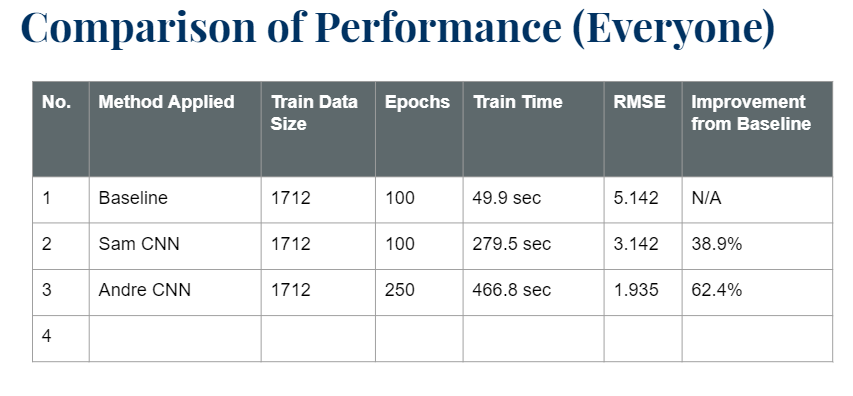

In [21]:
Image(os.path.join(workDir, "images/model_performance_table.png"))

### Analyzing Model Performance by Feature

Some information about our findings regarding model perfomance at the individual feature level:

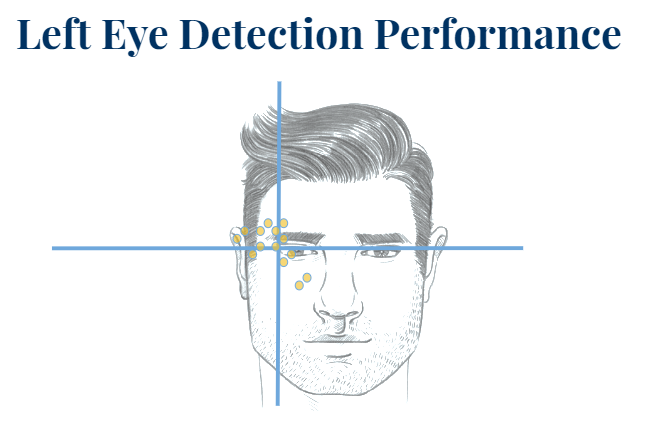

In [22]:
Image(os.path.join(workDir, "images/feature_performance_analysis.png"))

### Leaderboard Performance

I think here we should score our model on the test set provided by the competition and put the image of our standing on the leaderboard here:

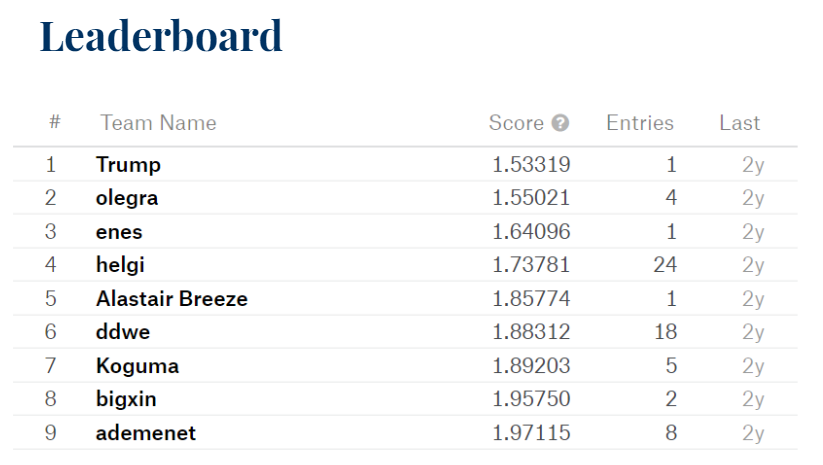

In [23]:
Image(os.path.join(workDir, "images/leaderboard.png"))

# Conclusion

### Applying the current state of the art methods to the facial point detection problem

 The current state of the art models use fully convolutional networks (FCN) which allow for pixel by pixel segmentation of the image. Here is an example:
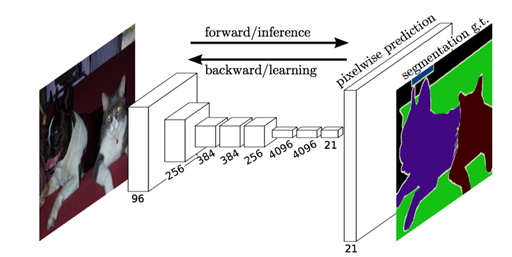

We can apply this approach the facial points’ detection problem by modifying the approach. First, we create Gaussian kernels around the projected facial point. Then we can up-sample the kernel using the Keras library to improve the image quality of the magnified kernel and feed the output through an FCN to segment the input pixel by pixel. 

There are certain roadblocks in this approach, firstly the varying angles and augmentations of the images would produce variance in the kernel and secondly, we will need to minimize three loss functions. The difference between the true kernel and the estimated kernel, secondly, the difference between the estimated kernel and the projected facial point and thirdly, the difference between the true kernel and the projected facial point. 

If the problem of minimizing the three loss functions can be solved the benefit of upsampling the image to segment the image may improve the result substantially.    


Section on:
potential purpose, limitations/reservations, and brief implementation discussion

### Things we think could help the model, but did not attempt


